In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# conn = sqlite3.connect("./backup/database_2024-08-12_09-23-18.db")

conn = sqlite3.connect("database.db")

sql = """
SELECT 
    BuergerBuero.stadt AS stadt,
    Termin.buergerbuero AS buergerbuero,
    Termin.datum AS datum,
    Termin.angelegenheit AS angelegenheit,
    Termin.erstmalsErfasstAlsFrei AS angelegt,
    Termin.erstmalsErfasstAlsBelegt AS belegt
FROM Termin
INNER JOIN BuergerBuero ON Termin.buergerbuero = BuergerBuero.stadtteil;
"""

df = pd.read_sql_query(sql, conn, parse_dates=["datum", "angelegt", "belegt"])
df.head()

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt
0,Dresden,Cotta,2024-08-19 09:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 16:41:58.374892
1,Dresden,Cotta,2024-08-26 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
2,Dresden,Cotta,2024-08-26 11:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
3,Dresden,Cotta,2024-08-26 11:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
4,Dresden,Cotta,2024-08-26 12:00:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666


In [232]:
df.describe()

,datum,angelegt,belegt
count,11900,11900,11390
mean,2024-09-06 02:40:54.806722560,2024-08-14 02:49:19.242104576,2024-08-14 12:06:14.548141056
min,2024-08-12 17:45:00,2024-08-12 15:31:19.138282,2024-08-12 15:35:42.034862
25%,2024-08-16 10:00:00,2024-08-12 16:53:24.401730048,2024-08-13 09:16:16.631939072
50%,2024-09-02 12:07:30,2024-08-13 21:51:04.686126080,2024-08-14 22:12:20.087451904
75%,2024-09-23 10:33:45,2024-08-15 07:02:06.728812032,2024-08-15 07:52:12.099343104
max,2024-12-07 12:45:00,2024-08-16 09:11:50.782079,2024-08-16 09:18:09.782361


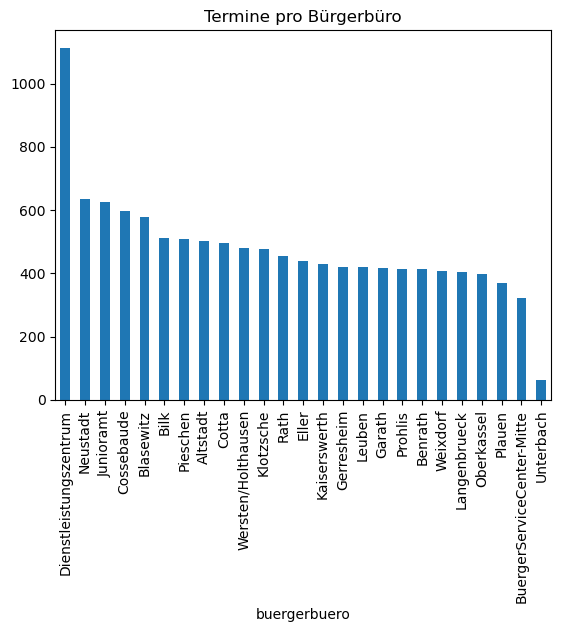

In [233]:
# Termine pro Bürgerbüro

df.buergerbuero.value_counts().plot(kind="bar")
plt.title("Termine pro Bürgerbüro")
plt.show()


In [241]:
# offene Termine pro Bürgerbüro
open_appointments = df[df["belegt"].isnull()]
open_appointments
# open_appointments = df[df["stadt"] == city].groupby("buergerbuero").offen.sum().sort_values(ascending=False)
# open_appointments.plot(kind="bar")

# plt.title("Offene Termine pro Bürgerbüro")
# plt.show()

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt,offen,weekday,hour,timeUntilTermin,timeTerminOpen
2324,Dresden,Plauen,2024-09-13 09:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,9,31 days 18:13:40.861718,NaT
2328,Dresden,Plauen,2024-09-13 10:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,10,31 days 19:13:40.861718,NaT
2330,Dresden,Plauen,2024-09-13 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,11,31 days 19:43:40.861718,NaT
2331,Dresden,Plauen,2024-09-13 11:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,11,31 days 19:58:40.861718,NaT
2335,Dresden,Plauen,2024-09-16 08:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,0,8,34 days 17:13:40.861718,NaT
...,...,...,...,...,...,...,...,...,...,...,...
11891,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:25:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:22:50.923901,NaT
11892,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:30:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:27:50.923901,NaT
11893,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:35:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:32:50.923901,NaT
11894,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:40:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:37:50.923901,NaT


In [242]:
open_appointments

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt,offen,weekday,hour,timeUntilTermin,timeTerminOpen
2324,Dresden,Plauen,2024-09-13 09:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,9,31 days 18:13:40.861718,NaT
2328,Dresden,Plauen,2024-09-13 10:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,10,31 days 19:13:40.861718,NaT
2330,Dresden,Plauen,2024-09-13 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,11,31 days 19:43:40.861718,NaT
2331,Dresden,Plauen,2024-09-13 11:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,4,11,31 days 19:58:40.861718,NaT
2335,Dresden,Plauen,2024-09-16 08:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT,True,0,8,34 days 17:13:40.861718,NaT
...,...,...,...,...,...,...,...,...,...,...,...
11891,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:25:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:22:50.923901,NaT
11892,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:30:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:27:50.923901,NaT
11893,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:35:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:32:50.923901,NaT
11894,Duesseldorf,Dienstleistungszentrum,2024-09-06 12:40:00,Personalausweis - Antrag,2024-08-16 09:02:09.076099,NaT,True,4,12,21 days 03:37:50.923901,NaT


In [243]:
# nächster freier Termin pro Bürgerbüro
city = "Duesseldorf"


In [244]:
df["weekday"] = df["datum"].dt.weekday
df["hour"] = df["datum"].dt.hour

df['timeUntilTermin'] = df['datum'] - df['angelegt']
df['timeTerminOpen'] = df['belegt'] - df['angelegt']

<Axes: >

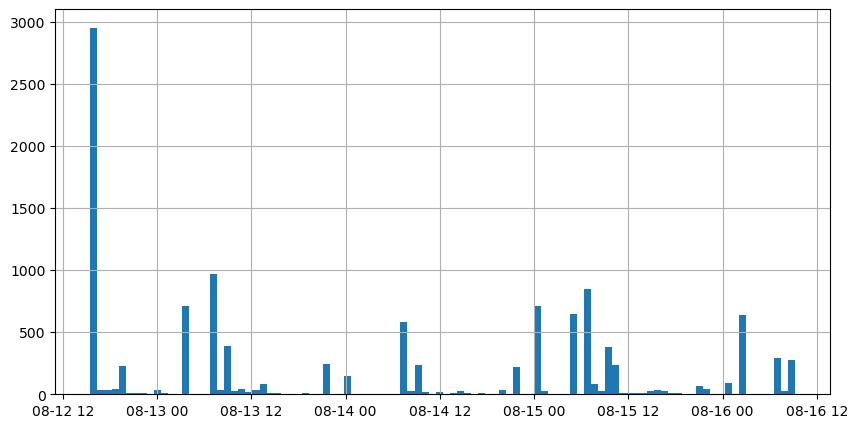

In [245]:
# histogram
df['angelegt'].hist(bins=100, figsize=(10, 5))


Text(0, 0.5, 'Anzahl der verfügbaren Termine')

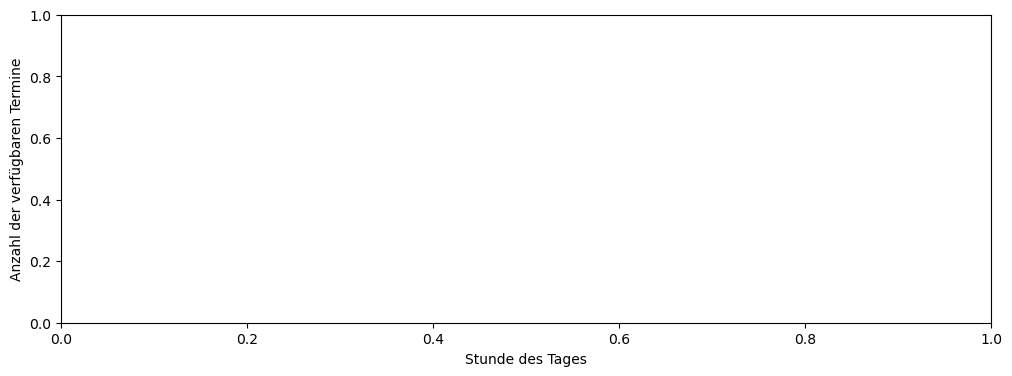

In [246]:
fig, axs = plt.subplots(figsize=(12,4))

# group by hour of the day
# df.groupby(df['erstmalsErfasstAlsFrei'].dt.hour).size().plot(kind='bar', ax=axs)

plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl der verfügbaren Termine')

Text(0, 0.5, 'Anzahl der verfügbaren Termine')

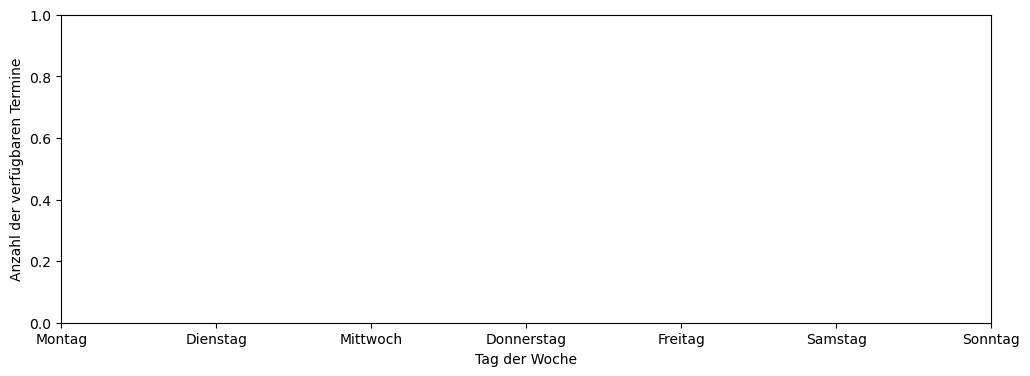

In [247]:
fig, axs = plt.subplots(figsize=(12,4))


axs.set_xticks(range(7))
axs.set_xticklabels(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])

# df.groupby(df['erstmalsErfasstAlsFrei'].dt.dayofweek).size().plot(kind='bar', ax=axs)

plt.xlabel('Tag der Woche')
plt.ylabel('Anzahl der verfügbaren Termine')